In [114]:
from cvxpylayers.torch import CvxpyLayer
import cvxpy as cp
import torch
import numpy as np
import matplotlib.pyplot as plt

In [115]:
x_dim, y_dim, ncon = 1, 1, 10

_c = cp.Parameter(y_dim)
_A = cp.Parameter((ncon, y_dim))
_b = cp.Parameter(ncon)
_S = cp.Parameter((ncon, x_dim))
_x = cp.Parameter(x_dim)
_xp = cp.Variable(x_dim)
_y = cp.Variable(y_dim)

obj = cp.Minimize(_c @ _y)
cons = [_A @ _y - _S @ _xp <= _b,
         _xp == _x,
         _y <= 1,
         _y >= -1]

prob = cp.Problem(obj, cons)

layer = CvxpyLayer(prob, parameters=[_c, _A, _b, _S, _x], variables=[_y, _xp])

# Initialize parameters
torch.manual_seed(6)
c = torch.nn.Parameter(torch.rand(y_dim, requires_grad=True))
#c = torch.nn.Parameter(torch.FloatTensor(y_dim).uniform(-4, 4).requires_grad_())
A = torch.nn.Parameter(torch.rand(ncon, y_dim, requires_grad=True))
#A = torch.nn.Parameter(torch.FloatTensor(ncon, y_dim).uniform(-4, 4).requires_grad_())
b = torch.nn.Parameter(10.0 * torch.rand(ncon, requires_grad=True))
#b = torch.nn.Parameter(torch.FloatTensor((ncon)).uniform(0, 1000).requires_grad_())
S = torch.nn.Parameter(torch.rand(ncon, x_dim, requires_grad=True))
#S = torch.nn.Parameter(torch.FloatTensor(ncon, x_dim).uniform(-4, 4).requires_grad_())

In [116]:
def print_human(A, b, c, S, x):
    print("c is ", c.data.item())
    for con in range(ncon):
        print("Constraint ", con, ": y <= ", ((b[con] + S[con] * x) / A[con]).data.item())

In [119]:
# Setup the data
x_min, x_max = -1.0, 1.0
pha = 3.0
frq = 2.2
amp = 0.5 

num_train = 1500
num_test = 50

X_train = (x_max - x_min) * torch.randn(num_train) + x_min
Y_train = amp * torch.sin(frq * X_train + pha)
X_train = X_train.reshape(-1, 1)
Y_train = Y_train.reshape(-1, 1)
params = [c, A, b, S]
opt = torch.optim.Adam(params, lr=1e-5)

bsize = 1
ds = torch.utils.data.TensorDataset(X_train, Y_train)
dloader = torch.utils.data.DataLoader(ds, batch_size=bsize, shuffle=True)

loss = torch.nn.MSELoss()

epochs = 1
cnt = 0
for epoch in range(epochs):
    for Xb, Yb in dloader:
        opt.zero_grad()
        try:
            Yp = layer(c, A, b, S, Xb)
        except:
            print_human(A, b, c, S, Xb[0])
            break

        #Yp = layer(c)[0]
        l = loss(Yp[0], Yb)
        l.backward()
        opt.step()
        
        print(
            '\r Loss: ',
            "{:.2e}".format(l.data.item()), end="")


 Loss:  1.80e+00Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.
c is  0.5737091302871704
Constraint  0 : y <=  5.95736026763916
Constraint  1 : y <=  4.55177116394043
Constraint  2 : y <=  6.166560173034668
Constraint  3 : y <=  -3.326551675796509
Constraint  4 : y <=  13.353899002075195
Constraint  5 : y <=  11.540319442749023
Constraint  6 : y <=  2.7728943824768066
Constraint  7 : y <=  4.706029891967773
Constraint  8 : y <=  2.972425937652588
Constraint  9 : y <=  -2.1542069911956787


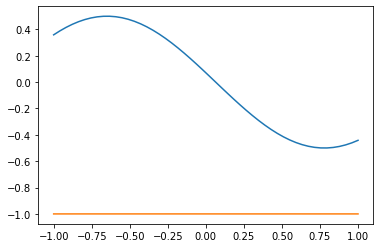

In [118]:
X_test = torch.linspace(x_min, x_max, num_test)
Y_test = amp * torch.sin(frq * X_test + pha)
X_test = X_test.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

Y_pred = layer(c, A, b, S, X_test)[0]

fig = plt.figure()
plt.plot(X_test.numpy().flatten(), Y_test.numpy().flatten())
plt.plot(X_test.numpy().flatten(), Y_pred.detach().numpy().flatten())

fig.show()